# Condiciones de entrega


Además de realizar al menos un envío replicando los resultados del paper antes mencionados, se deberá entregar el código del trabajo práctico junto a un breve informe que explique la idea del modelo implementado y una indicación de cómo ejecutar el programa si fuera necesaria. Ambos elementos se deben subir a un repositorio en github y enviar el link vìa campus. El trabajo podrá hacerse en grupos de hasta 3 personas. Los integrantes deben estar registrados enviando mail a cselmo@itba.edu.ar

# Fecha de entrega del TP


Para la evaluaciòn del TP como tal la fecha de vencimiento es el 4 de OCTUBRE a las 23:59hs. Para dicha fecha deberán resolver el problema utilizando un clasificador de texto basado en Naive Bayes Multinomial y otro en MLP. La estructura de validación debe quedar perfectamente clara en el informe (Hold-out Validation, K-folding, etc).

# Para la evaluación del TP se debe informar claramente:

1) Técnica de validación utilizada. La metodología con respecto a este punto debe ser impecable. ✔️

2) Elección de una métrica primaria ✔️

3) Informar las métricas secundarias: Precision, Recall, F1-Score y ROC-AUC, explicando claramente qué mide cada una de ellas, sus ventajas y desventajas.

4) Para las métricas mencionadas anteriormente realizar una interpretaciòn y comparación para el modelo NBMN y MLP.

5) En las conclusiones informar si el dataset posee o no sesgos en el armado de los datos.

# Librerías utilizadas

In [ ]:
 pip install dask[dataframe] --upgrade

     |████████████████████████████████| 125 kB 6.0 MB/s 


In [ ]:
import os
import time
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import dask.dataframe as dd
#Para el preprocesado
import nltk
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus   import stopwords
from nltk.tokenize import TreebankWordTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#Para los modelos
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
#Para metricas secundarias
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import seaborn as sns

# Cargar datos desde la carpeta de drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cambie el path donde se encuentran descargado los archivos:

In [ ]:
# Cargo los datos
path = "/content/drive/MyDrive/Redes TPS/TP Redes 1/"
df_train = pd.read_hdf(path+"train_data.hdf5")
df_valid = pd.read_hdf(path+"valid_data.hdf5")
df_test = pd.read_hdf(path+"test_data.hdf5")
df_submission = pd.read_csv(path+"submission_sample.csv", index_col="pairID")

# Analizamos los datos

Tenemos 4 archivos de datos.

Inicialmente, **df_train** está compuesto por 549367 registros de oraciones de texto y sus respectivas clasificaciones. Dichas clasificaciones pueden tomar 3 valores:

In [ ]:
print(np.unique(df_train['gold_label'].values))
print(np.unique(df_valid['gold_label'].values))
print(np.unique(df_submission['pred_labels'].values))

['contradiction' 'entailment' 'neutral']
['contradiction' 'entailment' 'neutral']
['contradiction' 'entailment' 'neutral']


Con este archivo se entrenarán ambos modelos, ajustando sus parámetros con iteraciones al evauar el modelo con el conjunto de datos **df_valid**, el cual posee 9842 registros. 
Una vez validado y optimizado a través de la métrica elegida (accuracy), se procesarán los datos de test, **df_test** (9842 registros también) con dicho modelo y son esas las respuestas que se subirán a la competencia para ser evaluados. **df_submission** son las clasificaciones reales del conjunto test con las que se comparará las predicciones realizadas por el modelo. El método de Hold out validation fue utilizado tras verificar la variabilidad del modelo sencillo visto en clase. Se realizó distintas particiones del conjunto de train y validación, entrenando el modelo y se verificó on las métricas que tuviesen baja varianza (ver subsección 'Verificamos la variabilidad de los resultados').

Los datos para validación y del test tienen una proporción del 18% aproximadamente en comparación del conjunto de datos de entrenamiento.

El dataset no tiene registros que contengan campos vacíos o incompletos, y entre las tres clases se encuentra balanceado, es decir, la cantidad de regitros son bastante parecidas entre si. Todo este analisis se muestra el código en las siguientes subsecciones.




### Visualizamos los datos

In [ ]:
print(df_train.shape)
df_train.head() 

(549367, 2)


,gold_label,text
pairID,,
1000092795.jpg#0r1c,contradiction,they are inside of a house
1000092795.jpg#0r1e,entailment,two guys are in a yard
1000092795.jpg#0r1n,neutral,They are doing yardwork
1000092795.jpg#1r1c,contradiction,A man is swimming.
1000092795.jpg#1r1e,entailment,Two young white men are near some bushes.


In [ ]:
print(df_valid.shape)
df_valid.head()

(9842, 2)


,gold_label,text
pairID,,
100197432.jpg#4r1c,contradiction,The women are seated in a bistro eating lunch.
100197432.jpg#4r1e,entailment,There are muliple women outdoors.
100197432.jpg#4r1n,neutral,The women are friends.
1026792563.jpg#1r1c,contradiction,A group of women are fishing
1026792563.jpg#1r1e,entailment,A group of women are selling their wares


In [ ]:
print(df_test.shape)
df_test.head()

(9824, 1)


,text
pairID,
0,The church has cracks in the ceiling.
1,The church is filled with song.
2,A choir singing at a baseball game.
3,The woman is young.
4,The woman is very happy.


In [ ]:
print(df_submission.shape)
df_submission.head()

(9824, 1)


,pred_labels
pairID,
0,entailment
1,neutral
2,entailment
3,contradiction
4,contradiction


### Checkeamos que no tengan registros nulos

In [ ]:
df_train.isna().sum()

gold_label    0
text          0
dtype: int64

In [ ]:
 df_valid.isna().sum()

gold_label    0
text          0
dtype: int64

In [ ]:
df_test.isna().sum()

text    0
dtype: int64

In [ ]:
df_submission.isna().sum()

pred_labels    0
dtype: int64

### Checkeamos si estaban balanceados entre categorías

**Podemos ver que en cuanto a clases tienen aproximadamente la misma proporción del total, el dataset está balanceado en este sentido.**

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_train['gold_label'])
h4=le.transform(df_train['gold_label'])
print(h4)

[0 1 2 ... 0 1 2]


In [ ]:
df_train['gold_label'].value_counts()

entailment       183416
contradiction    183187
neutral          182764
Name: gold_label, dtype: int64

## Verificamos la variabilidad de los resultados 

* dependiendo de la partición del conjunto de entrenamiento y validación 
* con el modelo visto en clase

Solo para comprobar, vamos a juntar en un mismo dataframe validación y entrenamiento para realizar 3 particiones de ese dataset total y verificar que los resultados del modelo no varíen demasiado.

In [ ]:
df_concat = pd.concat([df_train, df_valid])
df_concat

,gold_label,text
pairID,,
1000092795.jpg#0r1c,contradiction,they are inside of a house
1000092795.jpg#0r1e,entailment,two guys are in a yard
1000092795.jpg#0r1n,neutral,They are doing yardwork
1000092795.jpg#1r1c,contradiction,A man is swimming.
1000092795.jpg#1r1e,entailment,Two young white men are near some bushes.
...,...,...
985982384.jpg#3r1e,entailment,The men and women are dressed in clothes for t...
985982384.jpg#3r1n,neutral,The bathing suits are blue.
98756067.jpg#1r1c,contradiction,Two men trying to dance for a song


In [ ]:
train_score = []
valid_score = []
it=3
for i in range(it):
  seed = np.random.randint(0,60000)
  #divido en train y valid
  X_train, X_valid, y_train, y_valid = train_test_split(df_concat[['text']], df_concat[['gold_label']], test_size=0.2, random_state=seed)
  text_train = X_train["text"].tolist()
  text_valid = X_valid["text"].tolist()
  lab_train = y_train["gold_label"].tolist()
  lab_valid = y_valid["gold_label"].tolist()
  #armamos nuestro vocabulario
  cv = CountVectorizer(min_df=10, ngram_range = (1,2)) 
  cv_train = cv.fit_transform(text_train)
  cv_valid = cv.transform(text_valid)
  #armamos nuestro modelo y lo entrenamos con el vocbulario de entrenamiento
  clf = MultinomialNB(alpha=1e-10)
  clf.fit(cv_train, lab_train)
  #guardamos los valores del score de train y test para cada iteración
  train_score.append(clf.score(cv_train, lab_train))
  valid_score.append(clf.score(cv_valid, lab_valid))

In [ ]:
print(f"Scores para el entrenamiento: {train_score}")
print(f"Scores para la validación: {valid_score}")

Scores para el entrenamiento: [0.6490286498557113, 0.6483670006951787, 0.6484072361171029]
Scores para la validación: [0.6252838826201248, 0.6256951771248725, 0.6256772947551009]


**Como podemos ver previamente en cada iteración la variación tanto del accuracy para el conjunto de entrenamiento como para el conjunto de validación es muy chica, por lo tanto, podemos utilizar el método de validación de Hold out, con los conjuntos establecidos inicialmente. Dichos conjuntos se separarán en sus clases y el texto a procesar, y serán convertidos a listas a continuación.**

In [ ]:
text_train = df_train["text"].tolist()
labels_train = df_train["gold_label"].tolist()
text_val = df_valid["text"].tolist()
labels_val = df_valid["gold_label"].tolist()
text_test = df_test["text"].tolist()

# Preprocesamiento de los datos

Vamos a utilizar el módulo NLTK de forma de procesar el texto de las oraciones a lenguaje que la máquina pueda entender. Dentro de los preprocesamientos, encontramos:

* Stemming: para la normalización de las palabras agarra las raices de las palabras para considerar todas las variantes morfológicas de una palabra raíz a su significado principal, eliminando prefijos u sufijos de la palabra.

* Lemmatizacion: realiza también una normalizacion de las palabras teniendo en cuenta la raíz de la palabra en el diccionario, la raíz en el idioma en el que está.

* Eliminar stopwords, es decir, eliminar aquellas palabras que sean conectores, artículos que no aporten información en cuanto a significado, pero puede ser que aporten información respecto a la estructura.

* Quedarnos solo con aquellos ngrams que sean alfabéticos o no

* Pasar todo a minúsculas o mantenerlo igual

Lo que vamos a realizar al tockenizar es separar las oraciones por palabras para armar nuestro vocabulario de la mejor forma. La mejor forma la determinaremos con los parámetros y será la que nos brinde el mejor resultado de accuracy.

In [ ]:
#Descargamos los requerimientos para utlizar las funciones
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Inicializamos el PorterStemmer y WordnetLemmatizer
tokenizer  = TreebankWordTokenizer()
stemmer    = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Hiperparámetros a modificar en cada loop

Vamos a definir cada parámetro de los métodos de preprocesamiento y de Multinomial Naive Bayes para ajustar a su mejor desempeño a través de a fuerza bruta aunque esto implique un gran costo de tiempo de procesamiento y computacional. Los algoritmos presentados fueron extraídos de la Clase 2 de hiperparámetros en el github de la materia.

In [ ]:
#Definimos los hiperparámetros que vamos a utilizar en las transformaciones anteriores
# Hyperparameters (hp) considered for the classifier
hiperparameters = {
    'is_lem':       [True], #si usa o no lematización
    'is_stop':      [False],  #si elimina o no stopwords
    'is_stem':      [True],  #si realizar o no la stemización
    'is_alpha':     [False],  #si elimina valores no alfabeticos
    'is_lowerc':    [False],  #si pasa todo a minúscula
    'ngram_range':  [(1,3)], #limite menor e inferior del rango de n - palabras formando n-grams
    'min_df':       [3], #ignorar terminos con una frecuencia menor que min_df , int(15),int(30)
    'max_df':       [0.1],  #ignorar terminos con una frecuencia mayor que max_df 'default'
    'alpha':        [ 0.1] #1
}

In [ ]:
reg = []
#lo convertimos en un dataframe, primero apilando las opciones en una lista
for lem_b in hiperparameters['is_lem']:
  for stop_b in hiperparameters['is_stop']:
    for stem_b in hiperparameters['is_stem']:
      for alpha_b in hiperparameters['is_alpha']:
        for lower_b in hiperparameters['is_lowerc']:
          for ngram in hiperparameters['ngram_range']:
            for mindf in hiperparameters['min_df']:
              for maxdf in hiperparameters['max_df']:
                for alpha in hiperparameters['alpha']:
                      reg.append([lem_b,stop_b,stem_b,alpha_b,lower_b,ngram,mindf,maxdf,alpha])

hp = pd.DataFrame(reg, columns =['is_lem', 'is_stop','is_stem','is_alpha','is_lowercase','ngram_range','min_df','max_df','alpha'])
hp

,is_lem,is_stop,is_stem,is_alpha,is_lowercase,ngram_range,min_df,max_df,alpha
0,True,False,True,False,False,"(1, 3)",3,0.1,0.1


## Funciones

In [ ]:
def nltk_preprocessor_callback(**kwargs):
    """ kwargs -> hp
        Preprocesamiento con NLTK igual que en la clase anterior """

    def preprocessor(datapoint):
        raw_datapoint          = datapoint
        tokenized_datapoint    = tokenizer.tokenize(str(raw_datapoint))

        # Decide if we are going to lemmatize our data
        if kwargs.setdefault('is_lem', True):
            lemmatized_datapoint   = [lemmatizer.lemmatize(x,pos='v') for x in tokenized_datapoint]
        else:
            lemmatized_datapoint   = tokenized_datapoint

        # Decide if we are going to remove stopwords our data, kwargs -> hp
        if kwargs.setdefault('is_stop', True):
            nonstop_datapoint      = [x for x in lemmatized_datapoint if x not in stopwords.words('english')]
        else:
            nonstop_datapoint      = lemmatized_datapoint

        # Decide if we are going to apply stemming to our data, kwargs -> hp
        if kwargs.setdefault('is_stem', True):
            stemmed_datapoint      = [stemmer.stem(x) for x in nonstop_datapoint]
            filtered_datapoint     = stemmed_datapoint
        else:
            filtered_datapoint     = nonstop_datapoint
        
        # Skip this if not applying alpha
        if kwargs.setdefault('is_alpha', True):
            alphanumeric_datapoint = [x for x in filtered_datapoint if x.isalpha()]
            filtered_datapoint     = alphanumeric_datapoint

        return ' '.join(filtered_datapoint)

    return preprocessor

In [ ]:
def run_nltk_preprocessor(hp, dataset=None):
    print('NLTK Preprocessing...')
    to = time.time()
    data = pd.DataFrame()
    preprocessor = nltk_preprocessor_callback(
            is_lem=hp['is_lem'],
            is_stop=hp['is_stop'],
            is_stem=hp['is_stem'],
            is_alpha=hp['is_alpha']
            )
    ddataset = dd.from_pandas(dataset, npartitions=os.cpu_count())
    data['text'] = ddataset['text'].map_partitions(lambda df: df.apply(preprocessor)).compute(scheduler='multiprocessing')
    tf = time.time()
    print('finished in', (int(tf-to)), 'seconds.')
    return data

In [ ]:
def run_sklearn_preprocessor(hp, dataset_train=None, dataset_val=None, vect_type='cv'):
    print('sklearn preprocessing...')
    to = time.time()
    #Corremos el vectorizer que corresponde, igual que en clase anterior
    if hp['max_df'] == 'default': #se agregó este ifporque al dejar un max_df= 1, con un max_df rompe por ser max_df<min_df
      if vect_type == 'cv':
        print('CountVectorizer preprocessing...')
        cv = CountVectorizer(min_df=hp['min_df'], ngram_range=hp['ngram_range'],lowercase=hp['is_lowercase'])
      elif vect_type == 'tf':
        print('TfidfVectorizer preprocessing...')
        cv = TfidfVectorizer(min_df= hp['min_df'], ngram_range=hp['ngram_range'],lowercase=hp['is_lowercase'])
      else:
        print('Error: cv para CountVectorizer, tf para TfidVectorizer.')

    else:
      if vect_type == 'cv':
        print('CountVectorizer preprocessing...')
        cv = CountVectorizer(min_df=hp['min_df'], max_df=hp['max_df'], ngram_range=hp['ngram_range'],lowercase=hp['is_lowercase'])
      elif vect_type == 'tf':
        print('TfidfVectorizer preprocessing...')
        cv = TfidfVectorizer(min_df=hp['min_df'], max_df=hp['max_df'], ngram_range=hp['ngram_range'],lowercase=hp['is_lowercase'])
      else:
        print('Error: cv para CountVectorizer, tf para TfidVectorizer.')
    X = cv.fit_transform(dataset_train['text'])
    X_valid = cv.transform(dataset_val['text'])
    #np.random.seed(seed=random_seed)
    #np.random.shuffle(D)
    tf = time.time()
    print('finished in', (int(tf-to)), 'seconds.')
    return X, X_valid, cv

In [ ]:
#Callback para el procesamiento paralelo de Dask
def score_classifier(clf, X_train, Y_train, X_valid, Y_valid):
  print('Multinomial Naive Bayes processing...')
  to = time.time()
  #Aca defino el clasificador
  clf.fit(X_train, Y_train)
  tf = time.time()
  print('finished in', (int(tf-to)), 'seconds.')
  #return clf, clf.score(X_train, Y_train)
  return clf.score(X_train, Y_train), clf.score(X_valid, Y_valid)
  

# Prueba para una sola combinación de hiperparámetros

In [ ]:
for idx,hyperParam in hp.iterrows():
  break

In [ ]:
hyperParam

is_lem            True
is_stop           True
is_stem           True
is_alpha          True
is_lowercase      True
ngram_range     (1, 2)
min_df              10
max_df             0.5
alpha             0.01
Name: 0, dtype: object

In [ ]:
df_train.head(5)

,gold_label,text
pairID,,
1000092795.jpg#0r1c,contradiction,they are inside of a house
1000092795.jpg#0r1e,entailment,two guys are in a yard
1000092795.jpg#0r1n,neutral,They are doing yardwork
1000092795.jpg#1r1c,contradiction,A man is swimming.
1000092795.jpg#1r1e,entailment,Two young white men are near some bushes.


In [ ]:
data_train = run_nltk_preprocessor(hyperParam,df_train)

NLTK Preprocessing...
finished in 648 seconds.


In [ ]:
data_train.head(5)

,text
pairID,
1000092795.jpg#0r1c,insid hous
1000092795.jpg#0r1e,two guy yard
1000092795.jpg#0r1n,they yardwork
1000092795.jpg#1r1c,A man swim
1000092795.jpg#1r1e,two young white men near bush


In [ ]:
df_train.head(1)

,gold_label,text
pairID,,
1000092795.jpg#0r1c,contradiction,they are inside of a house


In [ ]:
df_valid.head(5)

,gold_label,text
pairID,,
100197432.jpg#4r1c,contradiction,The women are seated in a bistro eating lunch.
100197432.jpg#4r1e,entailment,There are muliple women outdoors.
100197432.jpg#4r1n,neutral,The women are friends.
1026792563.jpg#1r1c,contradiction,A group of women are fishing
1026792563.jpg#1r1e,entailment,A group of women are selling their wares


In [ ]:
data_valid = run_nltk_preprocessor(hyperParam,df_valid)
data_valid.head(5)

NLTK Preprocessing...
finished in 11 seconds.


,text
pairID,
100197432.jpg#4r1c,the women seat bistro eat lunch
100197432.jpg#4r1e,there mulipl women outdoor
100197432.jpg#4r1n,the women friend
1026792563.jpg#1r1c,A group women fish
1026792563.jpg#1r1e,A group women sell war


In [ ]:
cv_train, cv_valid, cv = run_sklearn_preprocessor(hyperParam, dataset_train = data_train, dataset_val= data_valid, vect_type='cv')
tf_train, tf_valid, tf = run_sklearn_preprocessor(hyperParam, dataset_train = data_train, dataset_val= data_valid, vect_type='tf')
Y_train = df_train['gold_label'].values
Y_valid = df_valid['gold_label'].values
cv_train[0:5], tf_train[0:5]

sklearn preprocessing...
CountVectorizer preprocessing...
finished in 8 seconds.
sklearn preprocessing...
TfidfVectorizer preprocessing...
finished in 8 seconds.


(<5x26636 sparse matrix of type '<class 'numpy.int64'>'
 	with 23 stored elements in Compressed Sparse Row format>,
 <5x26636 sparse matrix of type '<class 'numpy.float64'>'
 	with 23 stored elements in Compressed Sparse Row format>)

In [ ]:
cv_valid[0:5], tf_valid[0:5]

(<5x26636 sparse matrix of type '<class 'numpy.int64'>'
 	with 30 stored elements in Compressed Sparse Row format>,
 <5x26636 sparse matrix of type '<class 'numpy.float64'>'
 	with 30 stored elements in Compressed Sparse Row format>)

### trial paso por paso del fiteo del modelo de Multinomial Naive Bayes

In [ ]:
#Aca defino el clasificador
clf = MultinomialNB(alpha=hyperParam['alpha'], class_prior=None, fit_prior=False)

#### Solo imprime los resultados

In [ ]:
#fiteamos para countvectorizer
clf.fit(cv_train, Y_train)
print(f"Score con el train+Countvectorizer: {clf.score(cv_train, Y_train)}")
print(f"Score con el validation+Countvectorizer: {clf.score(cv_valid, Y_valid)}")

Score con el train+Countvectorizer: 0.6328792956256929
Score con el validation+Countvectorizer: 0.6277179435074172


In [ ]:
#fiteamos para countvectorizer
clf.fit(tf_train, Y_train)
print(f"Score con el train+TfidVectorizer: {clf.score(tf_train, Y_train)}")
print(f"Score con el validation+TfidVectorizer: {clf.score(tf_valid, Y_valid)}")

Score con el train+TfidVectorizer: 0.6396507252892875
Score con el validation+TfidVectorizer: 0.6322901849217639


### trial con la función

In [ ]:
scv = score_classifier(clf,cv_train,Y_train,cv_valid,Y_valid)
stf = score_classifier(clf,tf_train,Y_train,tf_valid,Y_valid)

Multinomial Naive Bayes processing...
finished in 3 seconds.
Multinomial Naive Bayes processing...
finished in 3 seconds.


In [ ]:
hp['Accuracy_cv_train'] = scv[0]
hp['Accuracy_cv_validation'] = scv[1]
hp['Accuracy_tf_train'] = stf[0]
hp['Accuracy_tf_validation'] = stf[1]

In [ ]:
hp

,is_lem,is_stop,is_stem,is_alpha,is_lowercase,ngram_range,min_df,max_df,alpha,Accuracy_cv_train,Accuracy_cv_validation,Accuracy_tf_train,Accuracy_tf_validation
0,True,True,True,True,True,"(1, 2)",10,0.5,0.01,0.632879,0.627718,0.639651,0.63229


# Varias combinaciones desde datos originales

In [ ]:
acc_cv_train = []
acc_cv_valid = []
acc_tf_train = []
acc_tf_valid = []
#random_seed = 27
for idx,hyperParam in hp.iterrows():
  data_train = run_nltk_preprocessor(hyperParam,df_train)
  data_valid = run_nltk_preprocessor(hyperParam,df_valid)
  cv_train, cv_valid, cv = run_sklearn_preprocessor(hyperParam, dataset_train = data_train, dataset_val= data_valid, vect_type='cv')
  tf_train, tf_valid, tf = run_sklearn_preprocessor(hyperParam, dataset_train = data_train, dataset_val= data_valid, vect_type='tf')
  Y_train = df_train['gold_label'].values
  Y_valid = df_valid['gold_label'].values
  clf = MultinomialNB(alpha=hyperParam['alpha'], class_prior=None, fit_prior=False)
  scv = score_classifier(clf,cv_train,Y_train,cv_valid,Y_valid)
  stf = score_classifier(clf,tf_train,Y_train,tf_valid,Y_valid)
  acc_cv_train.append(scv[0])
  acc_cv_valid.append(scv[1])
  acc_tf_train.append(stf[0])
  acc_tf_valid.append(stf[1])
  print('-----------')
  print('-----------')



NLTK Preprocessing...
finished in 650 seconds.
NLTK Preprocessing...
finished in 11 seconds.
sklearn preprocessing...
CountVectorizer preprocessing...
finished in 8 seconds.
sklearn preprocessing...
TfidfVectorizer preprocessing...
finished in 8 seconds.
Multinomial Naive Bayes processing...
finished in 3 seconds.
Multinomial Naive Bayes processing...
finished in 3 seconds.
-----------
-----------
NLTK Preprocessing...
finished in 645 seconds.
NLTK Preprocessing...
finished in 11 seconds.
sklearn preprocessing...
CountVectorizer preprocessing...
finished in 8 seconds.
sklearn preprocessing...
TfidfVectorizer preprocessing...
finished in 8 seconds.
Multinomial Naive Bayes processing...
finished in 3 seconds.
Multinomial Naive Bayes processing...
finished in 3 seconds.
-----------
-----------


In [ ]:
hp['Accuracy_cv_train'] = acc_cv_train
hp['Accuracy_cv_validation'] = acc_cv_valid
hp['Accuracy_tf_train'] = acc_tf_train
hp['Accuracy_tf_validation'] = acc_tf_valid
hp

,is_lem,is_stop,is_stem,is_alpha,is_lowercase,ngram_range,min_df,max_df,alpha,Accuracy_cv_train,Accuracy_cv_validation,Accuracy_tf_train,Accuracy_tf_validation
0,True,True,True,True,True,"(1, 2)",5,0.9,0.001,0.652536,0.63229,0.661814,0.635948
1,True,True,True,True,True,"(1, 2)",5,default,0.001,0.652536,0.63229,0.661814,0.635948


# Archivos de preprocesado con NLTK para ahorrar tiempo de ejecución

Se corrió al principio el algoritmo que se encuentra en la notebook 'Archivos NLTK' para obtener todos los archivos con los siguientes hiperparámetros:

hiperparameters = {

    'is_lem':       [True, False], #si usa o no lematización

    'is_stop':      [True, False],  #si elimina o no stopwords

    'is_stem':      [True, False],  #si realizar o no la stemización

    'is_alpha':     [True, False],  #si elimina valores no alfabeticos

    'is_lowerc':    [True, False],  #si pasa todo a minúscula

}

Se generó una función de acuerdo a los hiperparámetros definidos para cargar el dataframe correspondiente. Se dejaron los anteriores chunks de código de cargar los datasets de entrenamiento, validación y test, en el caso que se quisiera hacer el proceso de cero. El flujo de cero, se encuentra bajo el título de 'Varias combinaciones desde datos originales'. En caso de querer realizarse el flujo con los archivos preprocesados, correr los chunks de código bajo el título 'Flujo con archivos preprocesados de NLTK'.

In [ ]:
path

'/content/drive/MyDrive/Redes TPS/TP Redes 1/'

In [ ]:
def get_NLTK_data(hp,path):
  df = pd.read_csv(path+'/NLTK data/get_namefile.csv')
  filename_train = df.loc[(df['is_lem']==hp['is_lem']) & (df['is_stop']==hp['is_stop']) & (df['is_stem']==hp['is_stem']) & (df['is_alpha']==hp['is_alpha']) & (df['is_lowercase']==hp['is_lowercase']), 'X_train'].item()
  filename_valid = df.loc[(df['is_lem']==hp['is_lem']) & (df['is_stop']==hp['is_stop']) & (df['is_stem']==hp['is_stem']) & (df['is_alpha']==hp['is_alpha']) & (df['is_lowercase']==hp['is_lowercase']), 'X_valid'].item()
  data_train = pd.read_json(path+'/NLTK data/'+filename_train)
  data_valid = pd.read_json(path+'/NLTK data/'+filename_valid)
  print('NLTK preprocessed data loaded.')
  return data_train, data_valid

In [ ]:
data_train, data_valid = get_NLTK_data(hyperParam,path)
data_train

NLTK preprocessed data loaded.


,text
1000092795.jpg#0r1c,they be insid of a hous
1000092795.jpg#0r1e,two guy be in a yard
1000092795.jpg#0r1n,they be do yardwork
1000092795.jpg#1r1c,A man be swim .
1000092795.jpg#1r1e,two young white men be near some bush .
...,...
vg_verb9r4e,A famili gather around to play a video game
vg_verb9r4n,A famili enjoy the christma as they gather to ...
vg_verb9r5c,video game tear famili apart .
vg_verb9r5e,video game bring famili togeth .


### Flujo con archivos preprocesados por NLTK

In [ ]:
acc_cv_train = []
acc_cv_valid = []
acc_tf_train = []
acc_tf_valid = []
#random_seed = 27
for idx,hyperParam in hp.iterrows():
  data_train, data_valid = get_NLTK_data(hyperParam,path)
  cv_train, cv_valid, cv = run_sklearn_preprocessor(hyperParam, dataset_train = data_train, dataset_val= data_valid, vect_type='cv')
  tf_train, tf_valid, tf = run_sklearn_preprocessor(hyperParam, dataset_train = data_train, dataset_val= data_valid, vect_type='tf')
  Y_train = df_train['gold_label'].values
  Y_valid = df_valid['gold_label'].values
  clf = MultinomialNB(alpha=hyperParam['alpha'], class_prior=None, fit_prior=False)
  scv = score_classifier(clf,cv_train,Y_train,cv_valid,Y_valid)
  stf = score_classifier(clf,tf_train,Y_train,tf_valid,Y_valid)
  acc_cv_train.append(scv[0])
  acc_cv_valid.append(scv[1])
  acc_tf_train.append(stf[0])
  acc_tf_valid.append(stf[1])
  print('-----------')
  print('-----------')


NLTK preprocessed data loaded.
sklearn preprocessing...
CountVectorizer preprocessing...
finished in 17 seconds.
sklearn preprocessing...
TfidfVectorizer preprocessing...
finished in 17 seconds.
Multinomial Naive Bayes processing...
finished in 3 seconds.
Multinomial Naive Bayes processing...
finished in 3 seconds.
-----------
-----------


In [ ]:
hp['Accuracy_cv_train'] = acc_cv_train
hp['Accuracy_cv_validation'] = acc_cv_valid
hp['Accuracy_tf_train'] = acc_tf_train
hp['Accuracy_tf_validation'] = acc_tf_valid
hp

,is_lem,is_stop,is_stem,is_alpha,is_lowercase,ngram_range,min_df,max_df,alpha,Accuracy_cv_train,Accuracy_cv_validation,Accuracy_tf_train,Accuracy_tf_validation
0,True,False,True,False,False,"(1, 3)",3,0.1,0.1,0.704797,0.650376,0.71805,0.656167


# Guardar en los registros la nueva prueba con resultado

In [ ]:
reg = pd.read_json('/content/drive/MyDrive/Redes TPS/TP Redes 1/registros_pruebas_hp.csv')
reg

,is_lem,is_stop,is_stem,is_alpha,is_lowercase,ngram_range,min_df,max_df,alpha,Accuracy_cv_train,Accuracy_cv_validation,Accuracy_tf_train,Accuracy_tf_validation
0,True,True,True,True,True,"[1, 2]",0.05,0.5,0.001,0.358254,0.355619,0.359026,0.358159
1,True,True,True,True,True,"[1, 3]",0.05,0.5,0.001,0.358254,0.355619,0.359026,0.358159
2,True,True,True,True,True,"[1, 4]",0.05,0.5,0.001,0.358254,0.355619,0.359026,0.358159
3,True,True,True,True,True,"[1, 2]",0.05,0.75,0.001,0.358254,0.355619,0.359026,0.358159
4,True,True,True,True,True,"[1, 2]",0.05,0.9,0.001,0.358254,0.355619,0.359026,0.358159
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,False,True,False,False,"[1, 3]",3.00,0.1,0.100,0.706970,0.648649,0.720081,0.653424
93,False,False,False,True,True,"[1, 3]",3.00,0.1,0.100,0.708530,0.645499,0.721019,0.651595
94,False,False,False,True,False,"[1, 3]",3.00,0.1,0.100,0.710534,0.647023,0.723706,0.651697
95,False,False,False,False,True,"[1, 3]",3.00,0.1,0.100,0.709305,0.646617,0.721880,0.652408


In [ ]:
reg2 = pd.concat([reg,hp],ignore_index=True)

In [ ]:
reg2

,is_lem,is_stop,is_stem,is_alpha,is_lowercase,ngram_range,min_df,max_df,alpha,Accuracy_cv_train,Accuracy_cv_validation,Accuracy_tf_train,Accuracy_tf_validation
0,True,True,True,True,True,"[1, 2]",0.05,0.5,0.001,0.358254,0.355619,0.359026,0.358159
1,True,True,True,True,True,"[1, 3]",0.05,0.5,0.001,0.358254,0.355619,0.359026,0.358159
2,True,True,True,True,True,"[1, 4]",0.05,0.5,0.001,0.358254,0.355619,0.359026,0.358159
3,True,True,True,True,True,"[1, 2]",0.05,0.75,0.001,0.358254,0.355619,0.359026,0.358159
4,True,True,True,True,True,"[1, 2]",0.05,0.9,0.001,0.358254,0.355619,0.359026,0.358159
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,False,False,False,True,True,"[1, 3]",3.00,0.1,0.100,0.708530,0.645499,0.721019,0.651595
94,False,False,False,True,False,"[1, 3]",3.00,0.1,0.100,0.710534,0.647023,0.723706,0.651697
95,False,False,False,False,True,"[1, 3]",3.00,0.1,0.100,0.709305,0.646617,0.721880,0.652408
96,False,False,False,False,False,"[1, 3]",3.00,0.1,0.100,0.711439,0.648852,0.724568,0.653119


In [ ]:
reg2.to_json('/content/drive/MyDrive/Redes TPS/TP Redes 1/registros_pruebas_hp.csv')

# Cambios de los parámteros

Se inicio el ajuste de parámetros con valores elegidos arbitrariamentem haciéndole varias el mismo para distintos n_gram. 

In [ ]:
reg = pd.read_json(path+'registros_pruebas_hp.csv')
reg.tail(70)

,is_lem,is_stop,is_stem,is_alpha,is_lowercase,ngram_range,min_df,max_df,alpha,Accuracy_cv_train,Accuracy_cv_validation,Accuracy_tf_train,Accuracy_tf_validation
27,False,False,False,False,False,"[1, 2]",5.0,0.3,0.1,0.667803,0.643670,0.679613,0.649157
28,False,False,False,False,False,"[1, 2]",5.0,0.3,1.0,0.660504,0.642857,0.670038,0.649563
29,False,False,False,False,False,"[1, 2]",5.0,0.3,10.0,0.639423,0.631477,0.645192,0.636558
30,False,False,False,False,False,"[1, 2]",10.0,0.3,0.1,0.649535,0.639911,0.659568,0.645397
31,False,False,False,False,False,"[1, 2]",9.0,0.3,0.1,0.651934,0.640419,0.662095,0.646617
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,False,True,False,False,"[1, 3]",3.0,0.1,0.1,0.706970,0.648649,0.720081,0.653424
93,False,False,False,True,True,"[1, 3]",3.0,0.1,0.1,0.708530,0.645499,0.721019,0.651595
94,False,False,False,True,False,"[1, 3]",3.0,0.1,0.1,0.710534,0.647023,0.723706,0.651697
95,False,False,False,False,True,"[1, 3]",3.0,0.1,0.1,0.709305,0.646617,0.721880,0.652408


Al no ver cambios en el accuracy, se prosiguió a cambiar el max_df. Siendo este el parámetro que descarta aquellas palabras del vocabulario que superacen esa proporción respecto al total. El vocabulario parecía seguir siendo muy chico para ajustase bien en el entrenamiento. El accuracy seguía dando bajo.

Se agrandó aún más el max_df y se decidio eliminar el preprocesado por NLTk, de esta forma se pudo aumentar un poco más el accuracy. Se decidió bajar el max_df dando levemente mejor

Se cambió el min_df a 15, al pasarlo a un dato tipo int, desestima toda palabra que se repita en menos cantidad de registros que esa. Esto llevo a un valor cercano al ejemplo realizado en clase, dado que los parámetros eran parecidos. Se siguió iterando, disminuyendo el min_df, con lo cual se vió que aumentaba el accurracy siendo los valores máximos 3 y 5 dentro del descenso. Se prosiguió con ambos valores a ajustar el alpha, el hiperparámetro del Multinomial Naive Bayes.

Este hiperparámetro permite hacer un bias (smoothing Laplaciano) por sobre las probabilidades de las palabras que no se encuentren en todas los registros, tendiendo el likelihood de las probabilidades a una distribución uniforme.
El mejor resultado dió para alpha = 0.1 y 1.

Se volvieron a variar los parámetros de NLTK: 'is_lem', 'is_stop', 'is_stem', 'is_alpha','is_lowercase'. Esto dió como mejor resultado:

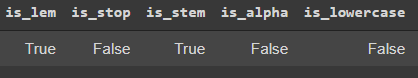





Paralelamente se realizaron alrededor de 500 pruebas a fuerza bruta, con un diccionario que contenia los parámetro psoibles. De todos modos, se alcanzó el mejor resultado de la forma anterior.


# Mejor parámetro

De la tabla con los scores realizados a partir de train

In [ ]:
best_cv_hp = hp.loc[hp['Accuracy_cv_validation'].idxmax()]
best_tf_hp = hp.loc[hp['Accuracy_tf_validation'].idxmax()]
if best_cv_hp['Accuracy_cv_validation'] >= best_tf_hp['Accuracy_tf_validation']:
  print("El Metodo de Count Vectorizer arroja mayor acccuracy")
  hyperParam_max_acc = best_cv_hp
  X_valid = cv_valid
else:
  print("El Metodo de TFIDVectorizer arroja mayor acccuracy")
  hyperParam_max_acc = best_tf_hp
  X_valid = tf_valid

El Metodo de TFIDVectorizer arroja mayor acccuracy


In [ ]:
hyperParam_max_acc

is_lem                        True
is_stop                      False
is_stem                       True
is_alpha                     False
is_lowercase                 False
ngram_range                 (1, 3)
min_df                           3
max_df                         0.1
alpha                          0.1
Accuracy_cv_train         0.704797
Accuracy_cv_validation    0.650376
Accuracy_tf_train          0.71805
Accuracy_tf_validation    0.656167
Name: 0, dtype: object

Dado que el método de TFIDVectorizer da un mejor acuuracy, elegimos este modelo

# Proceso test con el modelo con los mejores hiperparámetros

In [ ]:
stf = score_classifier(clf,tf_train,Y_train,tf_valid,Y_valid)
print(stf)
print('-----------')
print('-----------')

Multinomial Naive Bayes processing...
finished in 3 seconds.
(0.7180500466900996, 0.6561674456411298)
-----------
-----------


In [ ]:
data_test = run_nltk_preprocessor(hyperParam,df_test)
data_test.head(5)

NLTK Preprocessing...
finished in 4 seconds.


,text
pairID,
0,the church have crack in the ceil .
1,the church be fill with song .
2,A choir sing at a basebal game .
3,the woman be young .
4,the woman be veri happi .


In [ ]:
X_test = tf.transform(data_test['text'])

In [ ]:
test_class = clf.predict(X_test)

In [ ]:
test_class.shape

(9824,)

### Creamos el archivo que vamos a subir a la competencia

In [ ]:
#el ejemplo
df_submission

,pred_labels
pairID,
0,entailment
1,neutral
2,entailment
3,contradiction
4,contradiction
...,...
9819,contradiction
9820,neutral
9821,entailment


In [ ]:
submit = pd.DataFrame(data=test_class, columns=['pred_labels'])

In [ ]:
submit.index.names = ['pairID']
submit

,pred_labels
pairID,
0,contradiction
1,neutral
2,neutral
3,contradiction
4,neutral
...,...
9819,contradiction
9820,entailment
9821,contradiction


In [ ]:
submit.to_csv(path+'submission.csv')

# Saco las métricas

In [ ]:
def get_metrics(Y_valid, Y_valid_p):
  valid_metrics = []
  
  matriz_conf_valid = confusion_matrix(Y_valid, Y_valid_p)
  sns.heatmap(matriz_conf_valid,annot=True,cmap='Blues')

  #accuracy
  valid_metrics.append(accuracy_score(Y_valid, Y_valid_p))
  #precision
  valid_metrics.append(precision_score(Y_valid, Y_valid_p, average='macro'))
  #recall
  valid_metrics.append(recall_score(Y_valid, Y_valid_p, average='macro'))
  #f1-score
  valid_metrics.append(f1_score(Y_valid, Y_valid_p, average='macro'))

  metrics_valid = pd.DataFrame(valid_metrics, columns = ['Valores'] ,index = ['Accuracy','Precision','Recall','F1-score'])
  
  return metrics_valid#[accuracy,precision,recall,f1-score]

,Valores
Accuracy,0.656167
Precision,0.656158
Recall,0.656086
F1-score,0.656101


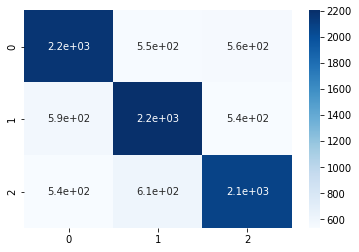

In [ ]:
metrics_valid = get_metrics(Y_valid, Y_valid_p)
metrics_valid

## Explicación de métricas

Las métricas que utilizamos en el modelo son calculadas a partir de la matriz de confusión entre las clases reales y predichas. Así se calculan los distintos valores de Verdadero Positivo (VP), Verdadero Negativo (VN), Falso Positivo (FP) y Falso Negativo (FN) para cada una de las clases, por ser un modelo multiclase. La métrica que utilizamos como primaria, es decir para ajustar el modelo, fue $Accuracy$. Esta última se calcula de la siguiente manera: $Accuracy  = \frac{VP + VN}{VP+VN+FP+FN}$ y básicamente representa el porcentaje total de elementos clasificados correctamente. Al ser multiclase, lo que se hace es justamente calcular las muestras que se clasificaron de manera correcta, es decir que coinciden en los vectores de las clases reales y predichas, y se calcula el porcentaje sobre el total. Es una de las métricas más utilizadas, aunque no es recomendable utilizarla para datasets no balanceados, ya que arroja resultados no representativos. 

Por otro lado usamos métricas secundarias que nos permiten evaluar el modelo, dentro de las cuales están: $Precision, Recall$ y $F1-Score$. La primera se calcula de la siguiente manera: $Precision  = \frac{VP}{VP+FP}$; y representa cuántas muestras fueron clasificadas correctamente como positivos dentro de todos los positivos. En el caso de multiclase para hacerlo se calcula la métrica para cada clase y luego se promedian sin ponderación, lo que se indica en la función como average = 'macro'. La segunda métrica, que también es llamada sensibilidad, se calcula de la siguiente manera:  $Recall = \frac{VP}{VP+FN}$; y representa cuántas muestras fueron clasificadas como positivas dentro del total de positivos verdaderos. Al igual que $Precision$, se utiliza el parámetro average = 'macro' para calcularla. Por último, la tercer métrica se calcula como $F1-Score  = \frac{2\cdot Precisión \cdot Recall}{Precisión + Recall}$, que permite relacionar las otras dos métricas secundarias previamente mencionadas, lo que es una gran ventaja ya que con una sola métrica podemos ver el balance entre la precisión y sensibilidad. Es un valor que va entre 0 y 1 y mientras más cercano a 1 quiere decir que las métricas involucradas son parecidas y cercanas a 1. 

Dentro de las funciones utilizadas para calcular las métricas de la librería sklearn también hay distintas opciones para calcular el promedio de los datos para el caso de modelos multiclase. Otra de las opciones a utilizar es 'micro', que va a calcular VP, VN, FP y FN para cada una de las clases y va a calcular las métricas con la suma de los parámetros. Este es un problemas para el caso de un modelo multiclase, dado que la $Precision$ y $Recall$ dan iguales, dado que al sumar los parámetros el valor de FN y FP van a ser iguales. 





# Comparación con MLP

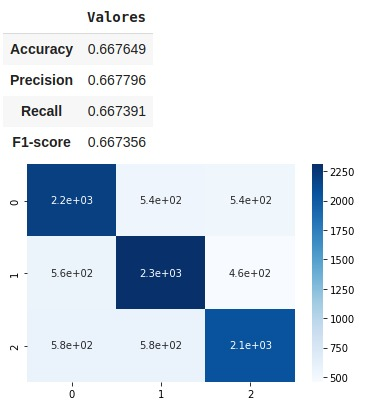

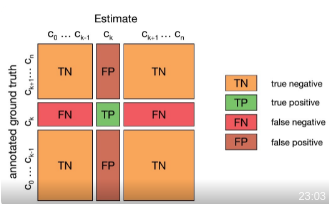

En ambos modelos la métrica de Accuracy, precision, recall y F1-score toman valores muy similares (dentro de un mismo modelo). Esto sucede porque para todas las clases la cantidad de falsos negativos es muy similar a la cantidad de falsos positivos (ver imagen), y por lo tanto precission y recall son muy similares.

Además podemos ver que todas las métricas mejoran con el modelo MLP. 

# Conclusiones

Para empezar los máximos accuracy al que pudimos llegar con los modelos fueron:

MNB (entrenamiento y validación) = 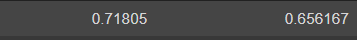 

Y al evaluar el test en la competencia de kaggle:

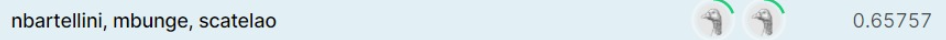

Los parámetros de preprocesado + alpha del mejor modelo encontrado para multinomial naive bayes fueron :
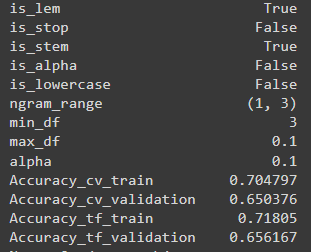

En cuanto a preprocesado por NLTK los únicos hiperparámetros que se mantuvieron fueron la de realizar la Lammatización y Stemming, extrayendo el significado y la raíz de las palabras para evitar diferenciaciones de las mismas que aumenten el vocabulario pero sin aportar verdadero valor.

Se ve que al eliminar los stopwords (como conectores o preposiciones), los elemento que no sean alfabéticos pierde levemente la información que estos podrían aportar y lo mismo pasa al quitar la mayúsculas.

El n_gram genera subsecuencias de tamaño 1 a n a partir de las hipótesis. El mejor valor generaba estos ngram de tamaño 1 a 3, por lo que se puede decir que parte de lo que infieren los modelos se encuentra en la estructura de la oración.

En cuanto al min_df y max_df podemos decir que en nuestros hallazgos: 

* Se descartaran aquellas n_grams que aparezcan en menos de 3 registros, es decir que incluye palabras que sean muy específicas a cada categoría y por ende a las clasificaciones.

* Se descartarán aquellas n_grams que tengan una aparición mayor que 0.1 en proporción al total. Al eliminar las palabras con tanta aparición se hace más selectivo el diccionario. 

Mientras con el modelo de MLP : 0.673 en validación


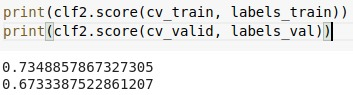

Y al evaluar la clasificación del test en la competencia: 

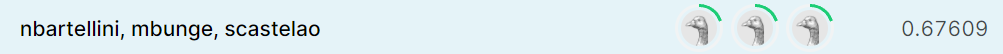

Suponemos que debido a la inicialización aleatoria de los pesos, el último modelo iterado con los mismo hiperparámetros dio levemente distinto. Dentro del notebook ' TP1 MLP' se encuentran detallados los hiperparámetros. El cual es el siguiente:

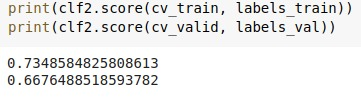


En conclusión, el MLP performó mejor. Opinamos que al tratarse de un modelo más complejo y con funciones no lineales, la red puede ajustarse mejor a los datos y encontrar relaciones entre el vocabulario y las categorías para clasificar mejor.

Para ambos casos en la carpeta se adjuntan los submissions realizados y los archivos de los hiperparámetros que se probaron.

En Gururangan et al., 2018 se demuestra que con una porcion significativa de los datos, el dataset deja pistas que puede hacer posible identificar la clasificación mirándolo solo la hipótesis sin ver la premisa. En ese paper se demuestra que un modelo de categorización simple se pueden clasificar con accuracy de 67% con SNLI.

Este valor fue alcanzado con el modelo MLP y hasta donde se pudo iterar se obtuvo un valor aproximado de  65%  con MNB.

Esto confirma lo expresado en el paper, por lo tanto, los datos poseen un sesgo, palabras que les permite inferir la clasificación con solo la hipótesis.
